## **Diabetes Prediction**

### **Project Setup**

In [1]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Core libraries for model development
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# Define project paths
BASE_DIR = '/Users/youhorng/Desktop/projects/diabetes-prediction'
DATA_DIR = os.path.join(BASE_DIR, 'data')

# Define dataset path
DATASET_PATH = os.path.join(DATA_DIR, 'diabetes_data.csv')

In [3]:
# Load the dataset
df = pd.read_csv(DATASET_PATH)

### **Data Understanding**

In [4]:
# Check the first few rows of the dataset
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [5]:
# Check the shape of the dataset
print(f"Total number of samples: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")

Total number of samples: 100000
Number of features: 9


In [6]:
# Check the basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [7]:
# Check for missing values
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [8]:
# Check for duplication
print(f"Number of duplicate rows: {df.duplicated().sum()}")

Number of duplicate rows: 3854


In [9]:
# Check the duplicated rows
df[df.duplicated(keep=False)].sort_values(by=list(df.columns)).head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
47708,Female,2.0,0,0,No Info,27.32,5.0,158,0
59468,Female,2.0,0,0,No Info,27.32,5.0,158,0
62073,Female,2.0,0,0,No Info,27.32,6.0,85,0
67439,Female,2.0,0,0,No Info,27.32,6.0,85,0
23617,Female,2.0,0,0,No Info,27.32,6.0,145,0


In [10]:
# Keep binary columns as integers for modeling (revert if they were converted to strings)
# We'll work with the original integer format for modeling
df_original = df.copy()

In [11]:
# Check the summary statistics
df.describe(include='all')

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000,100000.000000,100000.00000,100000.000000,100000,100000.000000,100000.000000,100000.000000,100000.000000
unique,3,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN
top,Female,NaN,NaN,NaN,No Info,NaN,NaN,NaN,NaN
freq,58552,NaN,NaN,NaN,35816,NaN,NaN,NaN,NaN
mean,NaN,41.885856,0.07485,0.039420,NaN,27.320767,5.527507,138.058060,0.085000
std,NaN,22.516840,0.26315,0.194593,NaN,6.636783,1.070672,40.708136,0.278883
min,NaN,0.080000,0.00000,0.000000,NaN,10.010000,3.500000,80.000000,0.000000
25%,NaN,24.000000,0.00000,0.000000,NaN,23.630000,4.800000,100.000000,0.000000
50%,NaN,43.000000,0.00000,0.000000,NaN,27.320000,5.800000,140.000000,0.000000
75%,NaN,60.000000,0.00000,0.000000,NaN,29.580000,6.200000,159.000000,0.000000


**Observation:** Based on the summary statistics above, we have found some interested facts.

- For features like `hypertension` and `heart_disease`, there are only 2 unique values which are yes (1) or no (0), and most of the data points are occupied with no (0) with 92K for hypertension and 96K for heart_disease.

- The target variable is `diabetes`, and according to the table above, we can see that it is very imbalanced as around 91K do not have diabetes. 

- There are some outliers that we found in features like `bmi`, and `blood_glucose_level`.

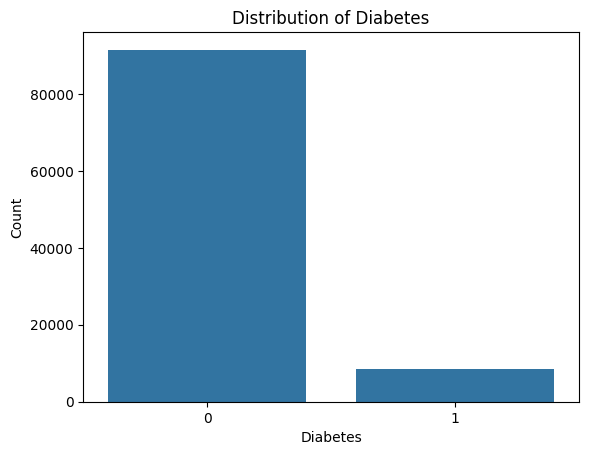

In [12]:
# Plot the distribution of the target variable
sns.countplot(x='diabetes', data=df)
plt.title('Distribution of Diabetes')
plt.xlabel('Diabetes')
plt.ylabel('Count')
plt.show()

In [13]:
# Check the outliers
def check_outliers_iqr(df, column):
    
    # Define the lower and upper bounds
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_df = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    return outliers_df, lower_bound, upper_bound

In [14]:
# Check the outliers for all numerical features
for col in df.select_dtypes(include='number').columns:
    outliers, _, _ = check_outliers_iqr(df, col)
    print(f"{col}: {len(outliers)} outliers")

age: 0 outliers
hypertension: 7485 outliers
heart_disease: 3942 outliers
bmi: 7086 outliers
HbA1c_level: 1315 outliers
blood_glucose_level: 2038 outliers
diabetes: 8500 outliers


**Inference:** Based on the inspection above, we have found.

- There no missing values in the dataset.

- There are 3854 duplicated rows.

- There are also outliers in three numerical columns such as `bmi`, `HbA1c_level`, and `blood_glucose_level`. 

### **Data Preparation**

In this section, we will:
- Remove duplicate rows
- Handle outliers in numerical features

In [15]:
# Create a working copy of the dataframe
df_clean = df_original.copy()

# Convert binary columns back to integers if they were converted to strings
binary_columns = ["hypertension", "heart_disease", "diabetes"]
for col in binary_columns:
    if df_clean[col].dtype == 'object':
        df_clean[col] = df_clean[col].astype(int)

print(f"Original dataset shape: {df_clean.shape}")
print(f"Data types:\n{df_clean.dtypes}")


Original dataset shape: (100000, 9)
Data types:
gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object


In [16]:
# Step 1: Remove duplicate rows
print(f"Number of duplicate rows before removal: {df_clean.duplicated().sum()}")
df_clean = df_clean.drop_duplicates()
print(f"Dataset shape after removing duplicates: {df_clean.shape}")
print(f"Removed {100000 - df_clean.shape[0]} duplicate rows")


Number of duplicate rows before removal: 3854
Dataset shape after removing duplicates: (96146, 9)
Removed 3854 duplicate rows


### **Data Preprocessing**

In this section, we will:
- Encode categorical variables
- Handle imbalanced data using SMOTE
- Scale the features


In [17]:
# Step 2: Handle outliers using IQR method
# We'll cap outliers instead of removing them to preserve data

numerical_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

print("Outlier handling (capping method):")
for col in numerical_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count outliers before capping
    outliers_before = ((df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)).sum()
    
    # Cap outliers
    df_clean[col] = df_clean[col].clip(lower=lower_bound, upper=upper_bound)
    
    # Count outliers after capping
    outliers_after = ((df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)).sum()
    
    print(f"{col}: {outliers_before} outliers capped (lower: {lower_bound:.2f}, upper: {upper_bound:.2f})")

print(f"\nFinal dataset shape: {df_clean.shape}")


Outlier handling (capping method):
age: 0 outliers capped (lower: -28.50, upper: 111.50)
bmi: 5354 outliers capped (lower: 13.71, upper: 39.55)
HbA1c_level: 1312 outliers capped (lower: 2.70, upper: 8.30)
blood_glucose_level: 2031 outliers capped (lower: 11.50, upper: 247.50)

Final dataset shape: (96146, 9)


In [ ]:
# Import additional libraries for preprocessing
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Separate features and target
X = df_clean.drop('diabetes', axis=1)
y = df_clean['diabetes']

print(f"Features shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")
print(f"\nTarget distribution percentage:\n{y.value_counts(normalize=True) * 100}")

Features shape: (96146, 8)
Target distribution:
diabetes
0    87664
1     8482
Name: count, dtype: int64

Target distribution percentage:
diabetes
0    91.178
1     8.822
Name: proportion, dtype: float64


In [ ]:
# Step 1: Encode categorical variables
categorical_cols = ['gender', 'smoking_history']

# Create a copy for encoding
X_encoded = X.copy()

# Use LabelEncoder for categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col])
    label_encoders[col] = le
    print(f"{col} encoding: {dict(zip(le.classes_, le.transform(le.classes_)))}")

print(f"\nEncoded features shape: {X_encoded.shape}")
print(f"\nEncoded features info:")
print(X_encoded.info())

gender encoding: {'Female': np.int64(0), 'Male': np.int64(1), 'Other': np.int64(2)}
smoking_history encoding: {'No Info': np.int64(0), 'current': np.int64(1), 'ever': np.int64(2), 'former': np.int64(3), 'never': np.int64(4), 'not current': np.int64(5)}

Encoded features shape: (96146, 8)

Encoded features info:
<class 'pandas.core.frame.DataFrame'>
Index: 96146 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               96146 non-null  int64  
 1   age                  96146 non-null  float64
 2   hypertension         96146 non-null  int64  
 3   heart_disease        96146 non-null  int64  
 4   smoking_history      96146 non-null  int64  
 5   bmi                  96146 non-null  float64
 6   HbA1c_level          96146 non-null  float64
 7   blood_glucose_level  96146 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 6.6 MB
None


In [ ]:
# Step 2: Split the data before applying SMOTE (to avoid data leakage)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"\nTraining set target distribution:\n{y_train.value_counts()}")
print(f"\nTest set target distribution:\n{y_test.value_counts()}")

Training set shape: (76916, 8)
Test set shape: (19230, 8)

Training set target distribution:
diabetes
0    70130
1     6786
Name: count, dtype: int64

Test set target distribution:
diabetes
0    17534
1     1696
Name: count, dtype: int64


In [ ]:
# Step 3: Handle imbalanced data using SMOTE
print("Before SMOTE:")
print(f"Training set shape: {X_train.shape}")
print(f"Target distribution:\n{y_train.value_counts()}")

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("\nAfter SMOTE:")
print(f"Training set shape: {X_train_balanced.shape}")
print(f"Target distribution:\n{pd.Series(y_train_balanced).value_counts()}")

Before SMOTE:
Training set shape: (76916, 8)
Target distribution:
diabetes
0    70130
1     6786
Name: count, dtype: int64

After SMOTE:
Training set shape: (140260, 8)
Target distribution:
diabetes
0    70130
1    70130
Name: count, dtype: int64


In [23]:
# Step 4: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

print(f"Scaled training set shape: {X_train_scaled.shape}")
print(f"Scaled test set shape: {X_test_scaled.shape}")


Scaled training set shape: (140260, 8)
Scaled test set shape: (19230, 8)


### **Feature Engineering**

Feature correlations with target variable (diabetes):
HbA1c_level            0.617548
blood_glucose_level    0.542330
age                    0.490317
bmi                    0.365027
smoking_history        0.119481
gender                 0.118211
hypertension           0.071952
heart_disease          0.048292
Name: diabetes, dtype: float64


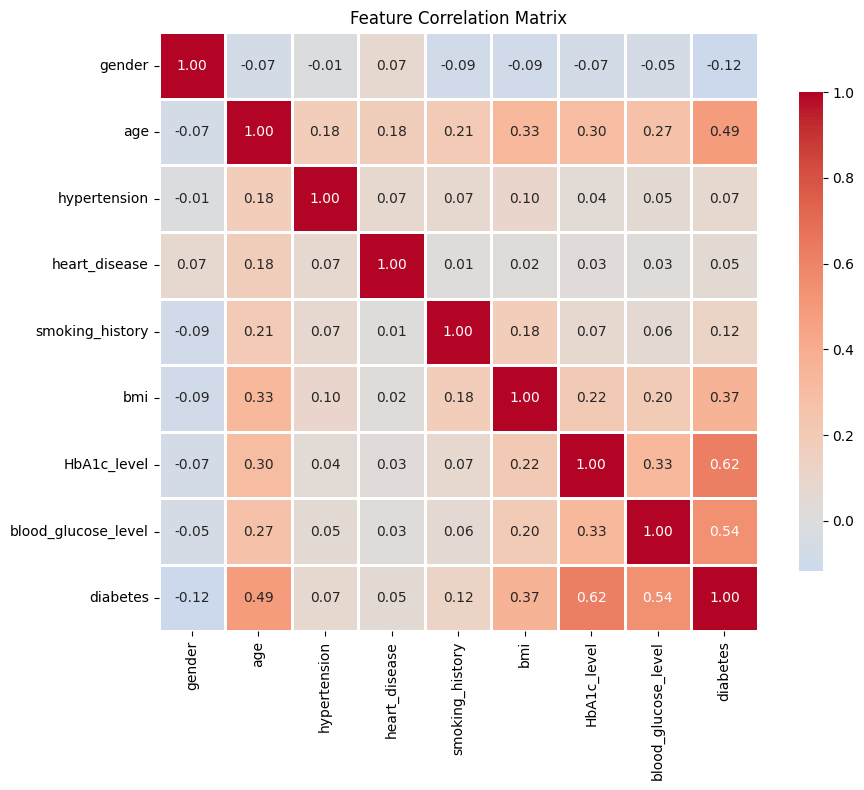

In [ ]:
# Create a dataframe with scaled features for correlation analysis
feature_names = X_encoded.columns.tolist()
df_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
df_scaled['diabetes'] = y_train_balanced

# Calculate correlation matrix
correlation_matrix = df_scaled.corr()

# Get correlations with target variable
target_correlations = correlation_matrix['diabetes'].drop('diabetes').abs().sort_values(ascending=False)

print("Feature correlations with target variable (diabetes):")
print(target_correlations)

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

In [ ]:
# Select features with correlation > 0.05 (threshold can be adjusted)
correlation_threshold = 0.05
selected_features = target_correlations[target_correlations > correlation_threshold].index.tolist()

print(f"Selected features (correlation > {correlation_threshold}):")
print(selected_features)
print(f"\nNumber of selected features: {len(selected_features)}")

# Update feature sets with selected features
feature_indices = [feature_names.index(f) for f in selected_features]
X_train_selected = X_train_scaled[:, feature_indices]
X_test_selected = X_test_scaled[:, feature_indices]

print(f"\nSelected training set shape: {X_train_selected.shape}")
print(f"Selected test set shape: {X_test_selected.shape}")

Selected features (correlation > 0.05):
['HbA1c_level', 'blood_glucose_level', 'age', 'bmi', 'smoking_history', 'gender', 'hypertension']

Number of selected features: 7

Selected training set shape: (140260, 7)
Selected test set shape: (19230, 7)


### **Model Training**

In [26]:
# Import additional models
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100)
}

# Train models and store results
model_results = {}
trained_models = {}

print("Training models...")
print("=" * 60)

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_selected, y_train_balanced)
    trained_models[name] = model
    
    # Make predictions
    y_pred = model.predict(X_test_selected)
    y_pred_proba = model.predict_proba(X_test_selected)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    model_results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    if roc_auc:
        print(f"ROC-AUC: {roc_auc:.4f}")

print("\n" + "=" * 60)
print("All models trained successfully!")


Training models...

Training Logistic Regression...
Accuracy: 0.8785
Precision: 0.4097
Recall: 0.8579
F1-Score: 0.5546
ROC-AUC: 0.9545

Training Decision Tree...
Accuracy: 0.9491
Precision: 0.7004
Recall: 0.7388
F1-Score: 0.7191
ROC-AUC: 0.8553

Training Random Forest...
Accuracy: 0.9593
Precision: 0.7900
Recall: 0.7341
F1-Score: 0.7610
ROC-AUC: 0.9630

All models trained successfully!


### **Model Evaluation**

In [27]:
# Create a comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Accuracy': [model_results[m]['accuracy'] for m in model_results.keys()],
    'Precision': [model_results[m]['precision'] for m in model_results.keys()],
    'Recall': [model_results[m]['recall'] for m in model_results.keys()],
    'F1-Score': [model_results[m]['f1_score'] for m in model_results.keys()],
    'ROC-AUC': [model_results[m]['roc_auc'] if model_results[m]['roc_auc'] else 0 for m in model_results.keys()]
})

print("Model Performance Comparison:")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("=" * 80)

# Find the best model based on F1-score (good balance between precision and recall)
best_model_name = comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Model']
print(f"\nBest Model (based on F1-Score): {best_model_name}")
print(f"Best Model Metrics:")
best_metrics = comparison_df[comparison_df['Model'] == best_model_name].iloc[0]
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']:
    print(f"  {metric}: {best_metrics[metric]:.4f}")


Model Performance Comparison:
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression  0.878471   0.409744 0.857901  0.554603 0.954519
      Decision Tree  0.949090   0.700391 0.738797  0.719082 0.855333
      Random Forest  0.959334   0.789975 0.734080  0.761002 0.962988

Best Model (based on F1-Score): Random Forest
Best Model Metrics:
  Accuracy: 0.9593
  Precision: 0.7900
  Recall: 0.7341
  F1-Score: 0.7610
  ROC-AUC: 0.9630


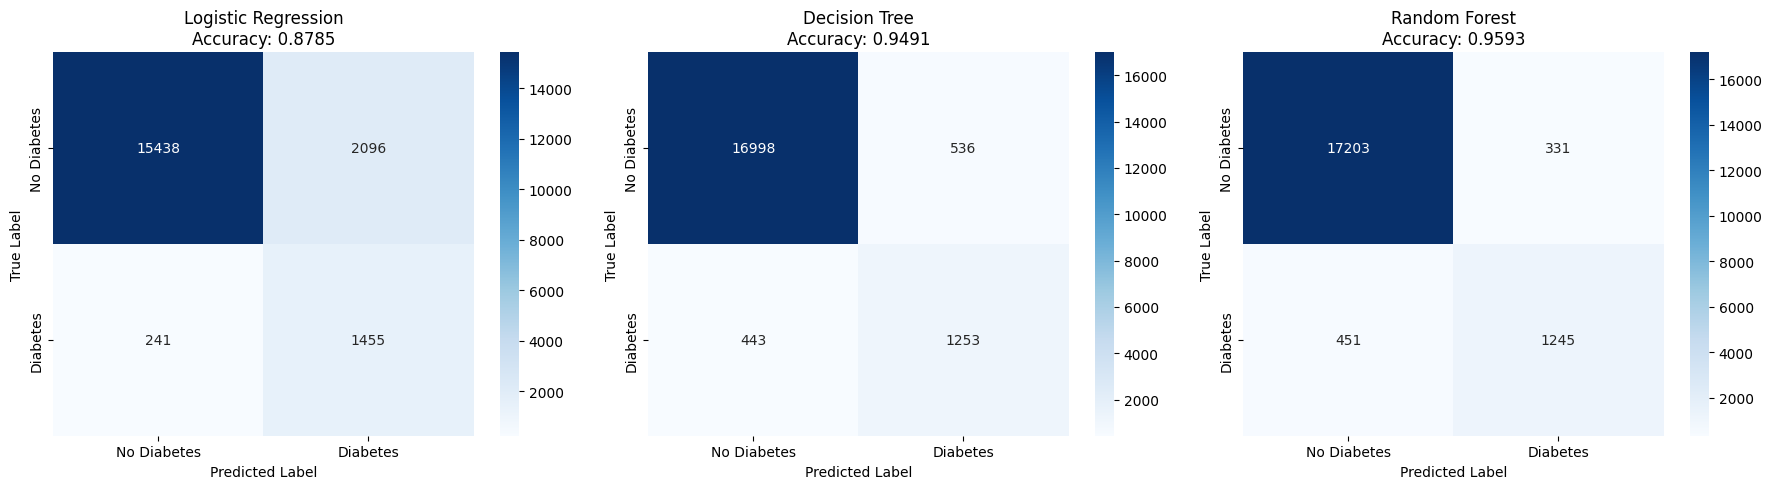

In [28]:
# Plot confusion matrices for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, results) in enumerate(model_results.items()):
    cm = confusion_matrix(y_test, results['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['No Diabetes', 'Diabetes'],
                yticklabels=['No Diabetes', 'Diabetes'])
    axes[idx].set_title(f'{name}\nAccuracy: {results["accuracy"]:.4f}')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

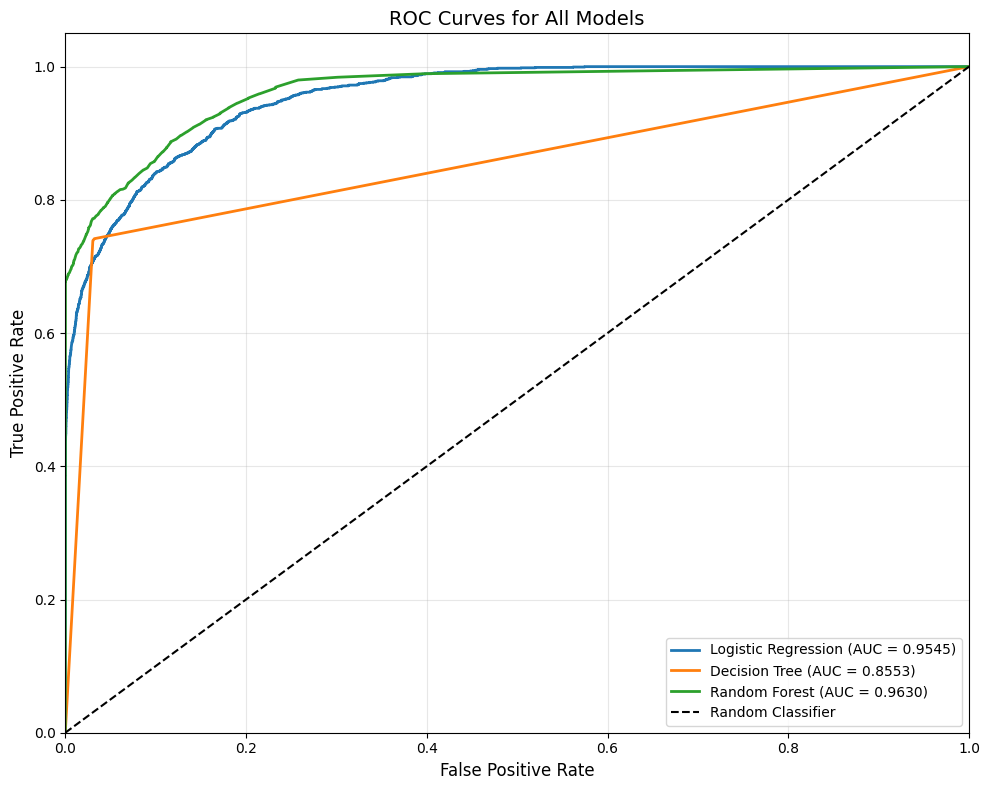

In [29]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

for name, results in model_results.items():
    if results['probabilities'] is not None:
        fpr, tpr, _ = roc_curve(y_test, results['probabilities'])
        plt.plot(fpr, tpr, label=f'{name} (AUC = {results["roc_auc"]:.4f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves for All Models', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [30]:
# Detailed classification reports
print("=" * 80)
print("DETAILED CLASSIFICATION REPORTS")
print("=" * 80)

for name, results in model_results.items():
    print(f"\n{name}:")
    print("-" * 80)
    print(classification_report(y_test, results['predictions'], 
                                target_names=['No Diabetes', 'Diabetes']))
    print()


DETAILED CLASSIFICATION REPORTS

Logistic Regression:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

 No Diabetes       0.98      0.88      0.93     17534
    Diabetes       0.41      0.86      0.55      1696

    accuracy                           0.88     19230
   macro avg       0.70      0.87      0.74     19230
weighted avg       0.93      0.88      0.90     19230



Decision Tree:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

 No Diabetes       0.97      0.97      0.97     17534
    Diabetes       0.70      0.74      0.72      1696

    accuracy                           0.95     19230
   macro avg       0.84      0.85      0.85     19230
weighted avg       0.95      0.95      0.95     19230



Random Forest:
--------------------------------------------------------------------------------
              p

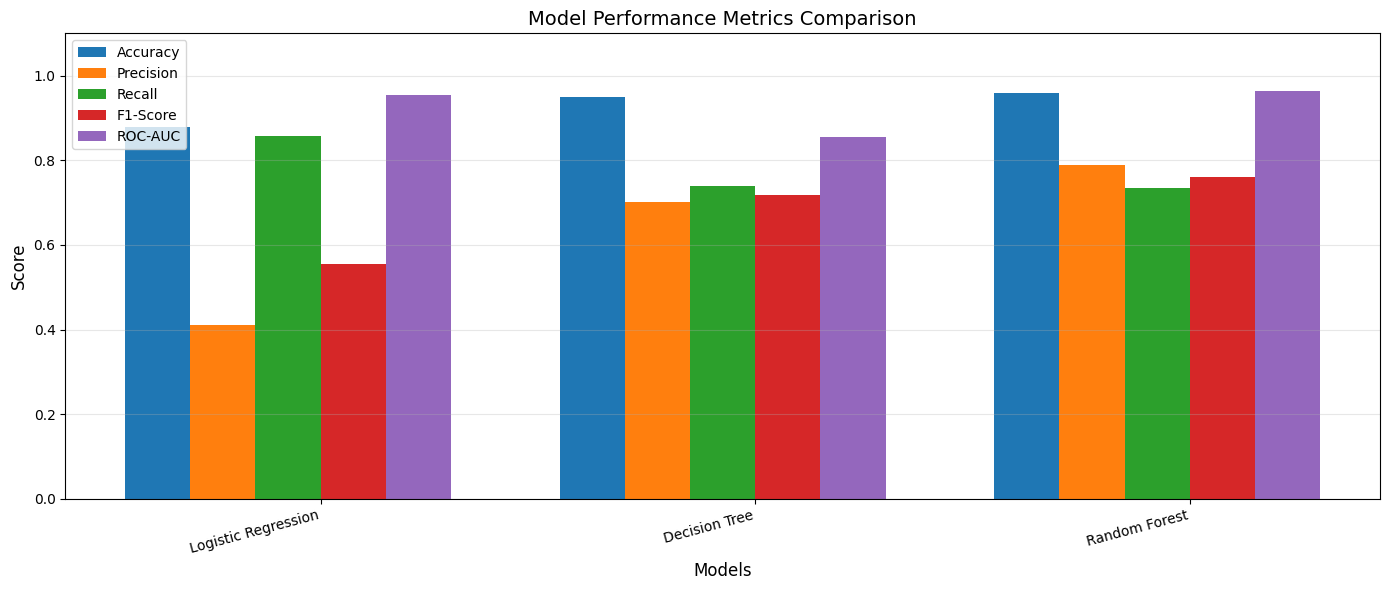

In [31]:
# Visualize metrics comparison
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(comparison_df))
width = 0.15

fig, ax = plt.subplots(figsize=(14, 6))
for i, metric in enumerate(metrics_to_plot):
    offset = width * (i - len(metrics_to_plot)/2)
    ax.bar(x + offset, comparison_df[metric], width, label=metric)

ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Metrics Comparison', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
ax.legend(loc='upper left')
ax.set_ylim([0, 1.1])
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


### **Save Model**

In this section, we will save the best model along with the preprocessing components.


In [32]:
# Import joblib for model saving
import joblib
import os

# Create models directory if it doesn't exist
MODELS_DIR = os.path.join(BASE_DIR, 'models')
os.makedirs(MODELS_DIR, exist_ok=True)

# Save the best model
best_model = trained_models[best_model_name]
model_path = os.path.join(MODELS_DIR, 'best_diabetes_model.pkl')
joblib.dump(best_model, model_path)
print(f"Best model ({best_model_name}) saved to: {model_path}")

# Save the scaler
scaler_path = os.path.join(MODELS_DIR, 'scaler.pkl')
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to: {scaler_path}")

# Save the label encoders
encoders_path = os.path.join(MODELS_DIR, 'label_encoders.pkl')
joblib.dump(label_encoders, encoders_path)
print(f"Label encoders saved to: {encoders_path}")

# Save selected features
features_path = os.path.join(MODELS_DIR, 'selected_features.pkl')
joblib.dump(selected_features, features_path)
print(f"Selected features saved to: {features_path}")

# Save feature indices for reference
feature_indices_path = os.path.join(MODELS_DIR, 'feature_indices.pkl')
joblib.dump(feature_indices, feature_indices_path)
print(f"Feature indices saved to: {feature_indices_path}")

print("\n" + "=" * 80)
print("All model components saved successfully!")
print("=" * 80)


Best model (Random Forest) saved to: /Users/youhorng/Desktop/projects/diabetes-prediction/models/best_diabetes_model.pkl
Scaler saved to: /Users/youhorng/Desktop/projects/diabetes-prediction/models/scaler.pkl
Label encoders saved to: /Users/youhorng/Desktop/projects/diabetes-prediction/models/label_encoders.pkl
Selected features saved to: /Users/youhorng/Desktop/projects/diabetes-prediction/models/selected_features.pkl
Feature indices saved to: /Users/youhorng/Desktop/projects/diabetes-prediction/models/feature_indices.pkl

All model components saved successfully!


In [33]:
# Create a summary of the saved model
model_summary = {
    'model_name': best_model_name,
    'model_type': type(best_model).__name__,
    'selected_features': selected_features,
    'performance_metrics': {
        'accuracy': float(model_results[best_model_name]['accuracy']),
        'precision': float(model_results[best_model_name]['precision']),
        'recall': float(model_results[best_model_name]['recall']),
        'f1_score': float(model_results[best_model_name]['f1_score']),
        'roc_auc': float(model_results[best_model_name]['roc_auc']) if model_results[best_model_name]['roc_auc'] else None
    },
    'training_samples': int(X_train_balanced.shape[0]),
    'test_samples': int(X_test.shape[0])
}

# Save model summary
import json
summary_path = os.path.join(MODELS_DIR, 'model_summary.json')
with open(summary_path, 'w') as f:
    json.dump(model_summary, f, indent=4)

print("Model Summary:")
print("=" * 80)
print(json.dumps(model_summary, indent=4))
print("=" * 80)
print(f"\nModel summary saved to: {summary_path}")


Model Summary:
{
    "model_name": "Random Forest",
    "model_type": "RandomForestClassifier",
    "selected_features": [
        "HbA1c_level",
        "blood_glucose_level",
        "age",
        "bmi",
        "smoking_history",
        "gender",
        "hypertension"
    ],
    "performance_metrics": {
        "accuracy": 0.959334373374935,
        "precision": 0.7899746192893401,
        "recall": 0.7340801886792453,
        "f1_score": 0.761002444987775,
        "roc_auc": 0.962987862799176
    },
    "training_samples": 140260,
    "test_samples": 19230
}

Model summary saved to: /Users/youhorng/Desktop/projects/diabetes-prediction/models/model_summary.json
